In [4]:
import pickle
from typing import Dict, Tuple, Sequence

import cv2
from skimage.color import rgb2lab, lab2rgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from functools import partial
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.InstanceNorm2d(out_channels))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None


    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion,
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class FeatureEncoder(nn.Module):
    def __init__(self):
        super(FeatureEncoder, self).__init__()

        # convolutional
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.norm1_1 = nn.InstanceNorm2d(64)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # residual blocks
        self.res1 = ResNetLayer(64, 128, block=ResNetBasicBlock, n=1)
        self.res2 = ResNetLayer(128, 256, block=ResNetBasicBlock, n=1)
        self.res3 = ResNetLayer(256, 512, block=ResNetBasicBlock, n=1)

    def forward(self, x):
        x = F.relu(self.norm1_1(self.conv1_1(x)))
        c4 = self.pool1(x)
        c3 = self.res1(c4)
        c2 = self.res2(c3)
        c1 = self.res3(c2)
        return c1, c2, c3, c4


def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
    )

class RecoloringDecoder(nn.Module):
    # c => (bz, channel, h, w)
    # [Pt, c1]: (18 + 512) -> (256)
    # [c2, d1]: (256 + 256) -> (128)
    # [Pt, c3, d2]: (18 + 128 + 128) -> (64)
    # [Pt, c4, d3]: (18 + 64 + 64) -> 64
    # [Illu, d4]: (1 + 64) -> 3

    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up_4 = double_conv(18 + 512, 256)
        self.dconv_up_3 = double_conv(256 + 256, 128)
        self.dconv_up_2 = double_conv(18 + 128 + 128, 64)
        self.dconv_up_1 = double_conv(18 + 64 + 64, 64)
        self.conv_last = nn.Conv2d(1 + 64, 3, 3, padding=1)


    def forward(self, c1, c2, c3, c4, target_palettes_1d, illu):
        bz, h, w = c1.shape[0], c1.shape[2], c1.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)

        # concatenate target_palettes with c1
        x = torch.cat((c1.float(), target_palettes.float()), 1)
        x = self.dconv_up_4(x)
        x = self.upsample(x)

        # concatenate c2 with x
        x = torch.cat([c2, x], dim=1)
        x = self.dconv_up_3(x)
        x = self.upsample(x)

        # concatenate target_palettes and c3 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)
        x = torch.cat([target_palettes.float(), c3, x], dim=1)
        x = self.dconv_up_2(x)
        x = self.upsample(x)

        # concatenate target_palettes and c4 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)
        x = torch.cat([target_palettes.float(), c4, x], dim=1)
        x = self.dconv_up_1(x)
        x = self.upsample(x)
        illu = illu.view(illu.size(0), 1, illu.size(1), illu.size(2))
        x = torch.cat((x, illu), dim = 1)
        x = self.conv_last(x)
        return x

In [6]:
def get_illuminance(img):
    """
    Get the luminance of an image. Shape: (h, w)
    """
    img = img.permute(1, 2, 0)  # (h, w, channel)
    img = img.numpy()
    img = img.astype(float) / 255.0 #EIDT float!!
    img_LAB = rgb2lab(img)
    img_L = img_LAB[:,:,0]  # luminance  # (h, w)
    return torch.from_numpy(img_L)

# pre-processsing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
])

In [7]:
# load model from saved model file 
state_path='./saved_models/7_try FE_RD.pth'
img_path='./datasets/data/input/img_429920.jpg'
pal_path='./datasets/data/old_palette/img_4299140.pkl'



state = torch.load(str(state_path),map_location=torch.device('cpu'))
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)

optimizer = torch.optim.AdamW(list(FE.parameters()) + list(RD.parameters()), lr=0.0002, weight_decay=4e-3)

FE.load_state_dict(state['FE'])
RD.load_state_dict(state['RD'])
optimizer.load_state_dict(state['optimizer'])

########

ori_img_load = transform(cv2.imread(str(img_path)))
ori_image=torch.unsqueeze(ori_img_load, dim=0)

illu_load = get_illuminance(ori_img_load)
illu=torch.unsqueeze(illu_load, dim=0)

ori_image = ori_image.double()
illu = illu.double()


new_palette_load = pickle.load(open(str(pal_path), 'rb'))
new_palette_load = new_palette_load[:, :6, :].ravel() / 255.0
new_palette_load = torch.from_numpy(new_palette_load).double()
new_palette_load.shape
new_palette = torch.unsqueeze(new_palette_load, dim=0)

######
flat_palette = new_palette.flatten()
c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
out = RD.forward(c1, c2, c3, c4, flat_palette.float().to(device), illu.float().to(device))

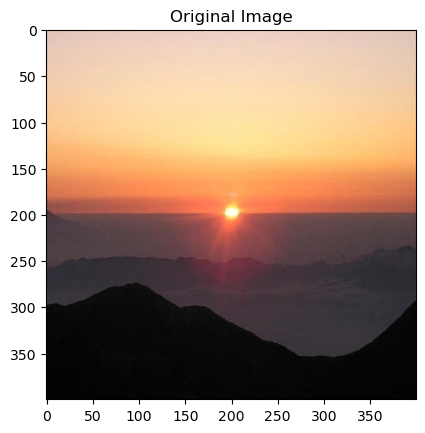

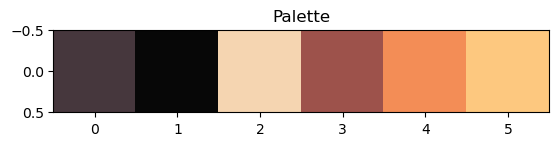

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


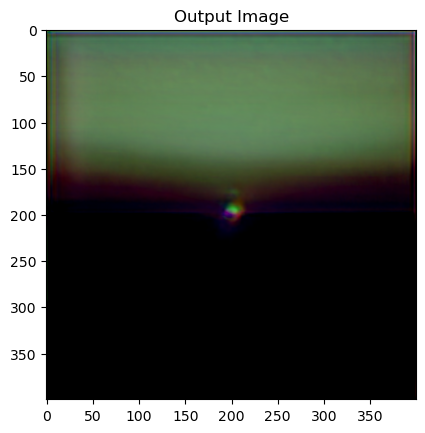

In [8]:
###viz
new_img = np.squeeze(ori_image, axis=0)
new_img = np.transpose(new_img, (1,2,0))
plt.imshow(new_img, interpolation='nearest')
plt.title("Original Image")
plt.show()

new_palette = new_palette.reshape((1, 6, 3))
plt.imshow(new_palette, interpolation='nearest')
plt.title("Palette")
plt.show()

new_out = np.squeeze(out, axis=0)
new_out = new_out.detach().cpu().numpy()
new_out = np.transpose(new_out, (1,2,0))
plt.imshow(new_out)
plt.title("Output Image")
plt.show()